# 01 Data Quality and Universe Overview

This notebook showcases data-loading and disclosure diagnostics:
- Load and validate disclosures and prices
- Inspect cross-person holdings coverage
- Visualize latest portfolio composition for a selected case study


## Notebook Flow

This walkthrough is split into three parts:
- validate raw data inputs
- inspect cross-person holdings coverage
- drill into one person's latest disclosed allocation


In [1]:
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import pandas as pd

ROOT = Path.cwd()
if not (ROOT / "src").exists() and (ROOT.parent / "src").exists():
    ROOT = ROOT.parent

sys.path.insert(0, str(ROOT / "src"))

from portfolio_bl.config import load_config
from portfolio_bl.data.disclosures import load_disclosures_csv, latest_portfolio_for_aliases
from portfolio_bl.data.prices import load_prices_csv

plt.style.use("seaborn-v0_8-whitegrid")
pd.options.display.float_format = "{:.4f}".format


In [2]:
cfg = load_config(ROOT / "configs/case_studies.yaml")
disclosures = load_disclosures_csv(cfg.disclosures_path)
prices = load_prices_csv(cfg.prices_path)

print(f"Disclosures rows: {len(disclosures):,}")
print(f"Price rows: {len(prices):,}")
print(f"Price tickers: {prices['ticker'].nunique()}")
disclosures.head()


Disclosures rows: 51
Price rows: 1,104
Price tickers: 46


,person,as_of_date,ticker,value_usd,source,person_norm
0,Donald Trump,2024-12-31,BND,175000,OGE 278e 2025 annual midpoint from reported ra...,donald trump
1,Donald Trump,2024-12-31,DGRO,375000,OGE 278e 2025 annual midpoint from reported ra...,donald trump
2,Donald Trump,2024-12-31,DJT,50000000,OGE 278e 2025 annual reported as Over $50M (lo...,donald trump
3,Donald Trump,2024-12-31,EMB,175000,OGE 278e 2025 annual midpoint from reported ra...,donald trump
4,Donald Trump,2024-12-31,LQD,175000,OGE 278e 2025 annual midpoint from reported ra...,donald trump


## Cross-Person Coverage

This section identifies how many holdings each person has in their latest snapshot and compares aggregate disclosed value.

In [3]:
latest_dates = disclosures.groupby("person_norm", as_index=False)["as_of_date"].max()
latest_rows = disclosures.merge(latest_dates, on=["person_norm", "as_of_date"], how="inner")

coverage = (
    latest_rows.groupby("person_norm")
    .agg(
        n_holdings=("ticker", "nunique"),
        total_value=("value_usd", "sum"),
    )
    .sort_values("total_value", ascending=False)
)
coverage


,n_holdings,total_value
person_norm,,
warren buffett,14,228429741845
nancy pelosi,22,133373000
donald trump,15,54975000


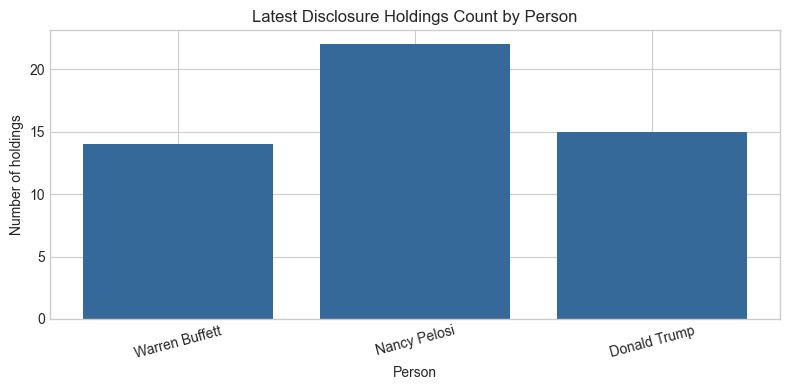

In [4]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(coverage.index.str.title(), coverage["n_holdings"], color="#34699A")
ax.set_title("Latest Disclosure Holdings Count by Person", pad=16)
ax.set_xlabel("Person")
ax.set_ylabel("Number of holdings")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


## Single-Person Drilldown

Pick a case-study key and inspect the latest disclosed portfolio used as the market-weight anchor in downstream experiments.

In [5]:
person_key = "buffett"
case_cfg = cfg.case_studies[person_key]
latest_portfolio, as_of_date = latest_portfolio_for_aliases(disclosures, case_cfg.disclosure_aliases)

latest_portfolio = latest_portfolio.sort_values("weight", ascending=False)
print(f"Latest portfolio for {case_cfg.person_label} ({as_of_date.date()}):")
latest_portfolio


Latest portfolio for Warren Buffett (2025-12-31):


,ticker,value_usd,weight
2,AXP,56088378465,0.2455
0,AAPL,38268369638,0.1675
3,BAC,28451276370,0.1246
9,KO,27964000000,0.1224
5,CVX,19837131131,0.0868
11,MCO,12565723807,0.0550
12,OXY,10894391643,0.0477
4,CB,10689854998,0.0468
8,KHC,7896644337,0.0346
7,GOOGL,5585842446,0.0245


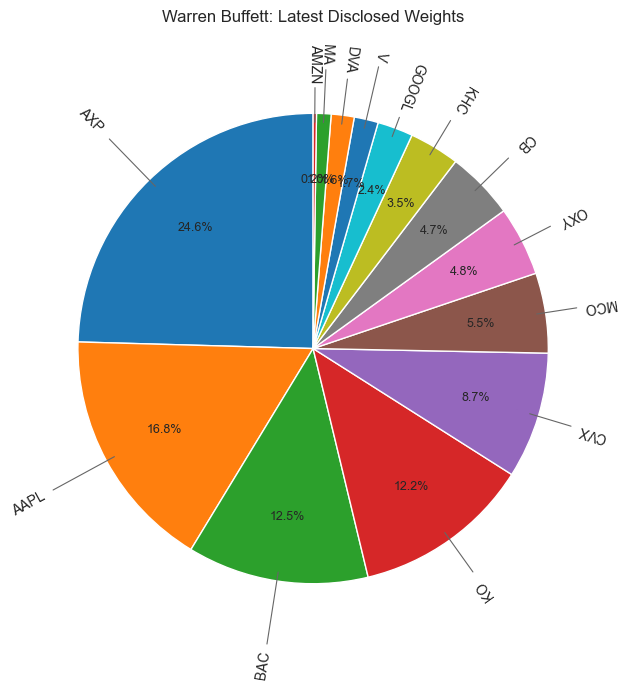

In [6]:
import numpy as np

fig, ax = plt.subplots(figsize=(9, 7))
wedges, _, autotexts = ax.pie(
    latest_portfolio["weight"],
    labels=None,
    autopct="%1.1f%%",
    startangle=90,
    pctdistance=0.72,
    wedgeprops={"linewidth": 1.0, "edgecolor": "white"},
)

for wedge, ticker in zip(wedges, latest_portfolio["ticker"]):
    angle = (wedge.theta1 + wedge.theta2) / 2.0
    x = np.cos(np.deg2rad(angle))
    y = np.sin(np.deg2rad(angle))

    x_text, y_text = 1.30 * x, 1.30 * y
    ha = "left" if x_text >= 0 else "right"

    rotation = angle if -90 <= angle <= 90 else angle + 180

    ax.annotate(
        ticker,
        xy=(0.95 * x, 0.95 * y),
        xytext=(x_text, y_text),
        ha=ha,
        va="center",
        rotation=rotation,
        rotation_mode="anchor",
        fontsize=10,
        arrowprops={"arrowstyle": "-", "lw": 0.8, "color": "0.4"},
    )

for t in autotexts:
    t.set_fontsize(9)

ax.set_title(f"{case_cfg.person_label}: Latest Disclosed Weights", pad=24)
ax.set_aspect("equal")
fig.subplots_adjust(top=0.86)
plt.tight_layout()
plt.show()


## Notes

- `data/raw/disclosures/disclosures.csv` is currently sourced from public filings for Buffett, Pelosi, and Trump.
- `data/raw/prices/prices.csv` is synthetic for demo reproducibility; replace with real prices for research-quality backtests.
